In [1]:
import boto3
import json
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

from botocore.exceptions import ClientError
from io import StringIO
from plotly.subplots import make_subplots

In [2]:
def get_secret():
    secret_name = "s3_data_analysis"
    region_name = "us-east-1"

    # Create a Secrets Manager client with default credentials
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        # Retrieve the secret value from Secrets Manager
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    # Extract the secret string (JSON object)
    secret = get_secret_value_response['SecretString']
    
    # Parse the secret string as JSON
    secrets = json.loads(secret)
    
    # Retrieve AWS credentials from the secrets
    aws_access_key_id = secrets['aws_access_key_id']
    aws_secret_access_key = secrets['aws_secret_access_key']
    
    # Now use the retrieved credentials to create the S3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key
    )

    return s3_client

s3_client = get_secret()

In [3]:
bucket_name = 'nk.data.analysis'
path = 'COVID_Analysis/covid_analysis'

In [4]:
files = [
    file["Key"].removeprefix("COVID_Analysis/covid_analysis/") for file in s3_client.list_objects_v2(Bucket=bucket_name, Prefix="COVID_Analysis/").get("Contents", [])
    if not file["Key"].endswith("/")
]

In [5]:
def read_csv_from_s3(bucket_name, key, s3_client):
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=key)
        csv_content = response['Body'].read().decode('utf-8')
        data = StringIO(csv_content)
        df = pd.read_csv(data)
        return df
    except Exception as e:
         print(f"Error reading CSV from S3: {e}")
         return None

In [6]:
for file in files:
    var_name = file.replace('.csv', '').replace('-', '_')  # Ensure valid variable names
    globals()[var_name] = read_csv_from_s3(bucket_name, path + '/' + file, s3_client)

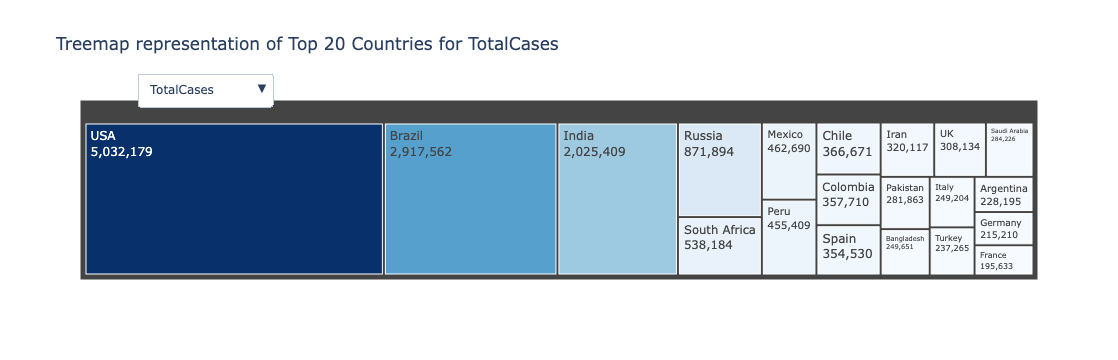

In [38]:
columns = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases']
colormap = {
    'TotalCases': 'Blues',
    'TotalDeaths': 'Reds',
    'TotalRecovered': 'Greens',
    'ActiveCases': 'Oranges'
}

fig = go.Figure()

for i, col in enumerate(columns):
    top_20 = worldometer_data.nlargest(20, col)
    
    fig.add_trace(go.Treemap(
        labels=top_20['Country/Region'],
        parents=[""] * len(top_20),
        values=top_20[col],
        textinfo="label+value",
        marker=dict(colorscale=colormap[col]),
        visible=True if i == 0 else False  # Show only the first dataset initially
    ))

dropdown_buttons = [
    dict(
        label=col,
        method="update",
        args=[{"visible": [col == c for c in columns]},
              {"title.text": f"Treemap representation of Top 20 Countries for {col}"}]
    ) for col in columns
]

fig.update_layout(
    title="Treemap representation of Top 20 Countries for TotalCases",
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=0.2,
        y=1.15
    )]
)

fig.show()

In [8]:
fig = px.line(day_wise, x='Date', y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
              title='COVID cases to Date', template='plotly_dark')

fig.update_layout(
    legend_title=None 
)

fig.show()

In [9]:
colors = ['#FF6347', '#DC143C', '#32CD32', '#FFD700', '#1E90FF']

fig = px.bar(worldometer_data.iloc[0:20], 
             x='Country/Region', 
             y=['Serious,Critical', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'TotalCases'])

fig.update_layout(
    legend_title=None,  
    colorway=colors,    
    title='COVID Cases by Country (Top 20)',
    template='plotly_dark'
)

fig.show()

In [10]:
def create_covid_subplots(data, columns, titles, top_n=20):
    """
    Function to create a 2x2 subplot of bar charts based on the provided columns and titles.
    
    Parameters:
    - data: DataFrame with the COVID data
    - columns: List of columns to be visualized (e.g., ['TotalCases', 'TotalDeaths', 'ActiveCases', 'TotalRecovered'])
    - titles: List of titles for each subplot
    - top_n: Number of top countries to display (default is 20)
    
    Returns:
    - fig: Plotly figure object
    """
    # Create subplots with 2 rows and 2 columns
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=titles,
        specs=[[{'type': 'bar'}, {'type': 'bar'}], [{'type': 'bar'}, {'type': 'bar'}]]
    )

    # Loop over each column and create a bar chart
    for i, (col, title) in enumerate(zip(columns, titles), start=1):
        sorted_data = data.sort_values(by=col, ascending=False).iloc[0:top_n]
        
        bar_chart = px.bar(
            sorted_data, 
            x=col, 
            y='Country/Region', 
            text=col, 
            color=col, 
            title=title
        )
        
        # Add the traces from the bar chart to the subplot
        for trace in bar_chart.data:
            row = (i - 1) // 2 + 1  # Determine the row (1 or 2)
            col = (i - 1) % 2 + 1   # Determine the column (1 or 2)
            fig.add_trace(trace, row=row, col=col)

    # Update layout
    fig.update_layout(
        template='plotly_dark',
        title_text='COVID Cases by Category for Top 20 Countries',
        showlegend=False,  # Hide legend to avoid duplication
        height=900,  # Adjust the height of the whole figure
        width=1200  # Adjust the width of the whole figure
    )

    return fig

# Columns and Titles for the subplots
columns = ['TotalCases', 'TotalDeaths', 'ActiveCases', 'TotalRecovered']
titles = [
    'Most confirmed COVID cases',
    'Most COVID death cases',
    'Most active COVID cases',
    'Most recovered COVID cases'
]


fig = create_covid_subplots(worldometer_data, columns, titles)
fig.show()


In [11]:
def create_pie_subplots(data, cases, top_n=15):
    """
    Function to create a 2x2 subplot of pie charts based on the provided cases.

    Parameters:
    - data: DataFrame with the COVID data
    - cases: List of cases to be visualized (e.g., ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases'])
    - top_n: Number of top countries to display (default is 15)

    Returns:
    - fig: Plotly figure object
    """
    # Extract the labels (Top countries)
    labels = data[0:top_n]['Country/Region'].values

    # Create subplots with 2 rows and 2 columns
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[f'{case}' for case in cases],
        specs=[[{'type': 'pie'}, {'type': 'pie'}], [{'type': 'pie'}, {'type': 'pie'}]]
    )

    # Loop over each case and create a pie chart
    for i, case in enumerate(cases, start=1):
        row = (i - 1) // 2 + 1  # Determines the row (1 or 2)
        col = (i - 1) % 2 + 1   # Determines the column (1 or 2)
        
        # Add a pie chart for each case
        fig.add_trace(
            go.Pie(labels=labels, values=data[0:top_n][case], hole=0.3),
            row=row, col=col
        )

    # Update layout to make the chart look cleaner
    fig.update_layout(
        height=800,
        width=800,
        title_text='Distribution of Cases: Worst 15 Affected Countries',
        template='plotly_dark'
    )

    return fig

# List of cases to visualize
cases = ['TotalCases', 'TotalDeaths', 'TotalRecovered', 'ActiveCases']

# Call the function and display the figure
fig = create_pie_subplots(worldometer_data, cases)
fig.show()


In [12]:
def create_ratio_bar_chart(data, numerator_col, denominator_col, title, top_n=50):
    """
    Function to create a bar chart for the ratio of two columns in the DataFrame.
    
    Parameters:
    - data: DataFrame with the data
    - numerator_col: Column name for the numerator
    - denominator_col: Column name for the denominator
    - title: Title for the chart
    - top_n: Number of top countries to display (default is 50)
    
    Returns:
    - fig: Plotly figure object
    """
    # Calculate the ratio and store it in a variable
    ratio = data[numerator_col] / data[denominator_col]

    # Add the ratio to the DataFrame temporarily for sorting and plotting
    data_sorted = data.assign(Ratio=ratio)

    # Sort the data by the ratio in descending order and limit to top N
    data_sorted = data_sorted.sort_values(by='Ratio', ascending=False).head(top_n)

    # Create the bar chart
    fig = px.bar(data_sorted, 
                 x='Country/Region', 
                 y='Ratio',
                 title=title,
                 labels={'Ratio': f'{numerator_col} to {denominator_col} Ratio'},
                 text='Ratio',  # Display the ratio value on top of bars
                 color='Ratio',  # Color by the ratio to emphasize differences
                 color_continuous_scale='reds',  # A color scale that goes from light to dark red
                 range_y=[0, data_sorted['Ratio'].max() + 0.1])  # Set the y-axis range for better spacing

    # Update layout to improve readability
    fig.update_layout(
        template='plotly_dark',
        xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
        title_text=title,
        showlegend=False,  # Remove legend since it's redundant
        height=600,  # Adjust the height of the figure for better spacing
        width=1000,  # Adjust the width of the figure for better clarity
    )

    return fig

# Example usage for different ratios:
# Deaths to Confirmed Cases
fig1 = create_ratio_bar_chart(worldometer_data, 'TotalDeaths', 'TotalCases', 'Death to Confirmed Cases Ratio by Country (Top 50)')
fig1.show()

# Deaths to Recovered Cases
fig2 = create_ratio_bar_chart(worldometer_data, 'TotalDeaths', 'TotalRecovered', 'Death to Recovered Cases Ratio by Country (Top 50)')
fig2.show()

# Tests to Confirmed Cases
fig3 = create_ratio_bar_chart(worldometer_data, 'TotalTests', 'TotalCases', 'Tests to Confirmed Cases Ratio by Country (Top 50)')
fig3.show()

# Serious/Critical to Death Cases
fig4 = create_ratio_bar_chart(worldometer_data, 'Serious,Critical', 'TotalDeaths', 'Serious/Critical to Deaths Ratio by Country (Top 50)')
fig4.show()




In [13]:
def country_visualization(df,country):
    
    data=df[df['Country/Region']==country]
    
    df=data.loc[:,['Date','Confirmed','Deaths','Recovered','Active']]
    
    fig = make_subplots(rows=1, cols=4,subplot_titles=("Confirmed", "Active", "Recovered",'Deaths'))
    
    fig.add_trace(
        go.Scatter(name="Confirmed",x=df['Date'],y=df['Confirmed']),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(name="Active",x=df['Date'],y=df['Active']),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(name="Recovered",x=df['Date'],y=df['Recovered']),
        row=1, col=3
    )

    fig.add_trace(
        go.Scatter(name="Deaths",x=df['Date'],y=df['Deaths']),
        row=1, col=4
    )

    fig.update_layout(height=600, width=1000, title_text="Date Vs Recorded Cases of {}".format(country),template="plotly_dark")
    fig.show()

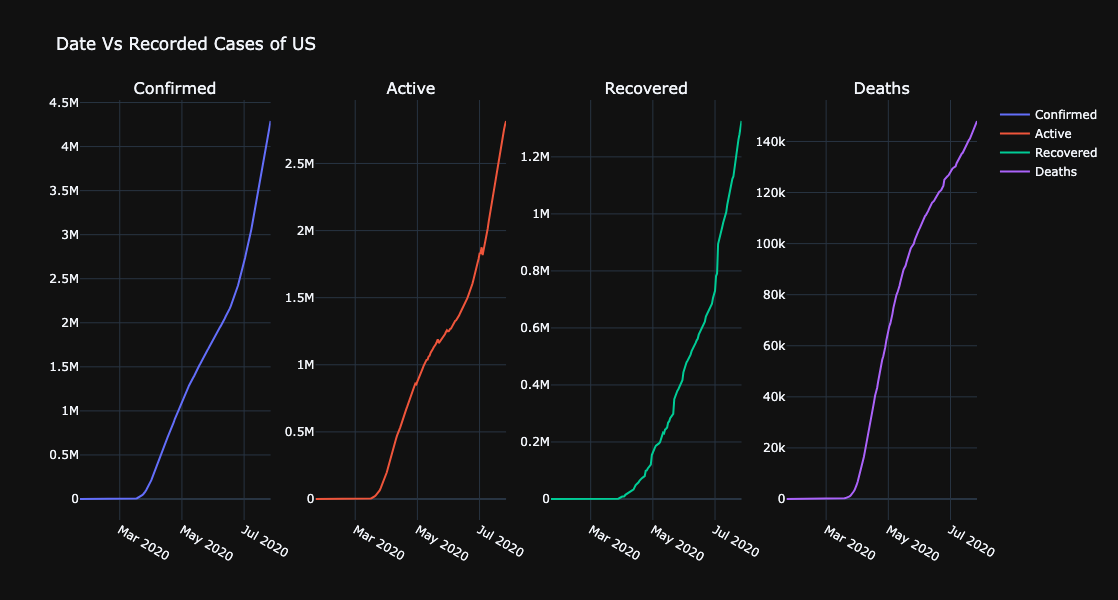

In [14]:
country_visualization(full_grouped,'US')